In [1]:
from functools import partial
import sys
sys.path.append('../src')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import KBio

In [2]:
lin = KBio.Linear
Gaus = KBio.Gaussian(sigma=1e-2)

In [3]:
np.random.seed(7)

In [4]:
def constant_forcing(A, t):
    return A * np.minimum(1, t/10)

In [36]:
beta = 8e-3
gamma = 1e-3
T_final = 3e1
dt = 1e-3  # for Euler step
data = KBio.rectangular_grid([0], [3e1], [30 + 1])
sim = KBio.SIS_sim(dt=dt, T_final=T_final, beta=beta, gamma=gamma, I0 = 5, S0 = 95)
sim(data, forcing = lambda x: 1.8e-4*np.sin(0.01 + 0.4*x))

In [38]:
n_samples_constant = 10
grids_constant = [KBio.rectangular_grid([0], [30], [301]) for _ in range(n_samples_constant)]

constant_values = np.random.normal(5e-4, 2e-4, n_samples_constant)
functions_constant = [partial(constant_forcing, constant_value) for constant_value in constant_values]
for grid, constant_value, fn in zip(grids_constant, constant_values, functions_constant):
    sim(grid, forcing = fn)

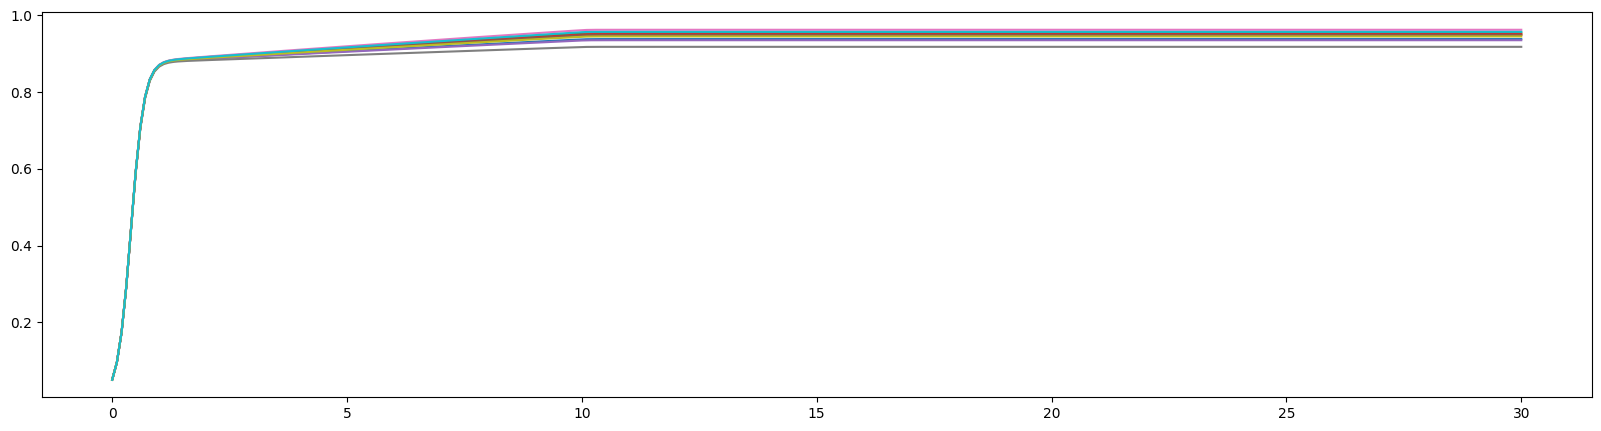

In [39]:
plt.figure(figsize=(20,5))
for grid in grids_constant:
    plt.plot(grid.grid_tensors[0], grid.grid_tensors_values)

In [40]:
grids_all = grids_constant

In [41]:
smoothed_data = []
smoothed_derivatives = []
alphas_list = [[0], [1], [2]]
x_data = np.stack([grid.grid_tensors[0] for grid in grids_all])
# x_data += np.random.normal(0, 1e-2, x_data.shape)
# standardize x_data to mean 0 variance 1
x_mean = np.mean(x_data)
x_std = np.std(x_data)

x_data = (x_data - x_mean) / x_std
y_data = np.stack([grid.grid_tensors_values for grid in grids_all])
# y_data += np.random.normal(0, 1e-3, y_data.shape)
f_data = np.stack([grid.grid_tensors_forcing for grid in grids_all])

# z, kdList, u_smoothed = KBio.kernel_smoothing(lin, x_grid = x_data, u_data = y_data, f_data = f_data, alpha_list=alphas_list, nugget=1e-8)

In [10]:
#z, kdList, u_smoothed = KBio.kernel_smoothing(lin, x_grid = x_data, u_data = y_data, f_data = f_data, alpha_list=alphas_list, nugget=1e-8)

#### smoothing: RBF, predictor(equation learning): poly_quad


In [42]:
poly_quad = KBio.Polynomial(degree=2, c=0)

In [43]:
z, kdList, u_smoothed = KBio.kernel_smoothing(Gaus, x_grid = x_data, u_data = y_data, f_data = f_data, alpha_list=alphas_list, nugget=1e-8)

Reshaping x_grid in smoother
(10, 301, 1)
n_grid_pts:  301


In [44]:
u_smoothed[0].shape

(301, 10)

In [45]:
feature_functions = []

def ident(index, x, u, u_deriv_list):
    """ Identity feature function for the $index$-th derivative of the function"""
    if np.abs(int(index) - index) > 1e-10:
        raise ValueError('Only the first derivative is available')
    if index == 0:
        return u
    else:
        return u_deriv_list[index]
# Get the first 2 derivatives and the function itself
for i in range(1,3):
    feature_functions.append(partial(ident, i))

# quadratic feature function
def quadratic(index, x, u, u_deriv_list):
    """ Quadratic feature function for the $index$-th derivative of the function

    The feature function is $u^2$ for the function itself and $2u u'$ for the first derivative.
    """

    if index == 0:
        return u**2
    elif index == 1:
        return 2*u*u_deriv_list[index]
    else:
        raise ValueError('Higher derivatives are not implemented')

feature_functions.append(partial(quadratic, 0))

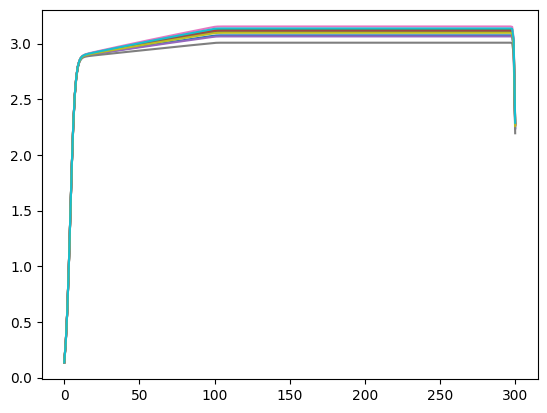

In [46]:
plt.plot(u_smoothed[0])

In [47]:
x_grid_list = grid.grid_list
f_data_flat = f_data.reshape(-1, 1)
F0 = KBio.assemble_features(x_grid_list=x_grid_list, u_smoothed=u_smoothed[0], multi_derivatives=u_smoothed, function_list=feature_functions)

F0_mean = np.mean(F0, axis=0)
F0_std = np.std(F0, axis=0)
F0 = np.divide((F0 - F0_mean), F0_std, where = (F0_std != 0))

In [48]:
F0.shape

(3010, 8)

In [63]:
predictor, weight_vector = KBio.learn_DE_form(kernel=poly_quad, s_features=F0, f_labels=f_data_flat, nugget=1e-8)

### Test with new constant forcing functions

In [50]:
np.random.seed(1947)

n_samples_constant = 10
grids_constant_test = [KBio.rectangular_grid([0], [30], [301]) for _ in range(n_samples_constant)]

constant_values_test = np.random.normal(5e-4, 2e-4, n_samples_constant)
functions_constant_test = [partial(constant_forcing, constant_value) for constant_value in constant_values]
for grid, constant_value, fn in zip(grids_constant_test, constant_values_test, functions_constant_test):
    sim(grid, forcing = fn)

In [51]:
x_data_test = np.stack([grid.grid_tensors[0] for grid in grids_constant_test])
x_data_test = (x_data_test - x_mean) / x_std

y_data_test = np.stack([grid.grid_tensors_values for grid in grids_constant_test])

f_data_test = np.stack([grid.grid_tensors_forcing for grid in grids_constant_test])

In [21]:
# f_data_test[0]

In [61]:
z_test, kdList_test, u_smoothed_test = KBio.kernel_smoothing(Gaus, x_grid = x_data_test, u_data = y_data_test, f_data = f_data_test, alpha_list=alphas_list, nugget=1e-8)

Reshaping x_grid in smoother
(10, 301, 1)
n_grid_pts:  301


In [67]:
# z_test, kdList_test, u_smoothed_test = KBio.kernel_smoothing(poly_quad, x_grid = x_data_test, u_data = y_data_test, f_data = f_data_test, alpha_list=alphas_list, nugget=1e-14)

In [62]:
F0_test = KBio.assemble_features(x_grid_list=x_grid_list, u_smoothed=u_smoothed_test[0], multi_derivatives=u_smoothed_test, function_list=feature_functions, flatten=False)
# standardize the test data
F0_test = np.divide((F0_test - F0_mean), F0_std, where = (F0_std != 0))

In [54]:
F0_mean

array([ 1.50000000e+01,  3.01424931e+00,  3.01424931e+00, -8.53153729e-01,
        6.01094792e+04, -8.53153729e-01,  6.01094792e+04,  9.19511229e+00])

In [55]:
F0_std

array([8.68907360e+00, 3.30776917e-01, 3.30776917e-01, 1.61047458e+01,
       6.93731419e+03, 1.61047458e+01, 6.93731419e+03, 1.29760273e+00])

In [56]:
F0_test.shape

(10, 301, 8)

In [57]:
s_test = np.zeros((F0_test.shape[1], F0_test.shape[1]))
for i in range(F0_test.shape[1]):
    for j in range(F0_test.shape[1]):
        s_test[i,j] = Gaus(F0_test[0,i,:], F0_test[0,j,:] )

In [64]:
preds_all = []
for i in range(F0_test.shape[0]):
    print(i)
    k_new, preds = predictor(F0_test[i,:,:])
    preds_all.append(preds)

0
(301, 3010) (3010, 1)
1
(301, 3010) (3010, 1)
2
(301, 3010) (3010, 1)
3
(301, 3010) (3010, 1)
4
(301, 3010) (3010, 1)
5
(301, 3010) (3010, 1)
6
(301, 3010) (3010, 1)
7
(301, 3010) (3010, 1)
8
(301, 3010) (3010, 1)
9
(301, 3010) (3010, 1)


In [65]:
preds_all[0]

array([[ 5.58376312e-04],
       [-1.17945671e-03],
       [ 7.92980194e-04],
       [ 1.67910010e-04],
       [-1.17510557e-04],
       [ 2.74062157e-04],
       [ 1.28597021e-04],
       [-1.01186335e-04],
       [-3.68934125e-05],
       [ 1.22641213e-04],
       [ 2.42739290e-04],
       [ 3.08764633e-04],
       [ 3.38735525e-04],
       [ 3.48932110e-04],
       [ 3.48776113e-04],
       [ 3.43583059e-04],
       [ 3.35747842e-04],
       [ 3.26951500e-04],
       [ 3.17703467e-04],
       [ 3.08381626e-04],
       [ 2.99152452e-04],
       [ 2.90042721e-04],
       [ 2.81042885e-04],
       [ 2.72426754e-04],
       [ 2.64002243e-04],
       [ 2.55775405e-04],
       [ 2.47819815e-04],
       [ 2.39959219e-04],
       [ 2.32473481e-04],
       [ 2.25196360e-04],
       [ 2.18135305e-04],
       [ 2.11308477e-04],
       [ 2.04756740e-04],
       [ 1.98312686e-04],
       [ 1.92158855e-04],
       [ 1.86221674e-04],
       [ 1.80561794e-04],
       [ 1.75005989e-04],
       [ 1.6

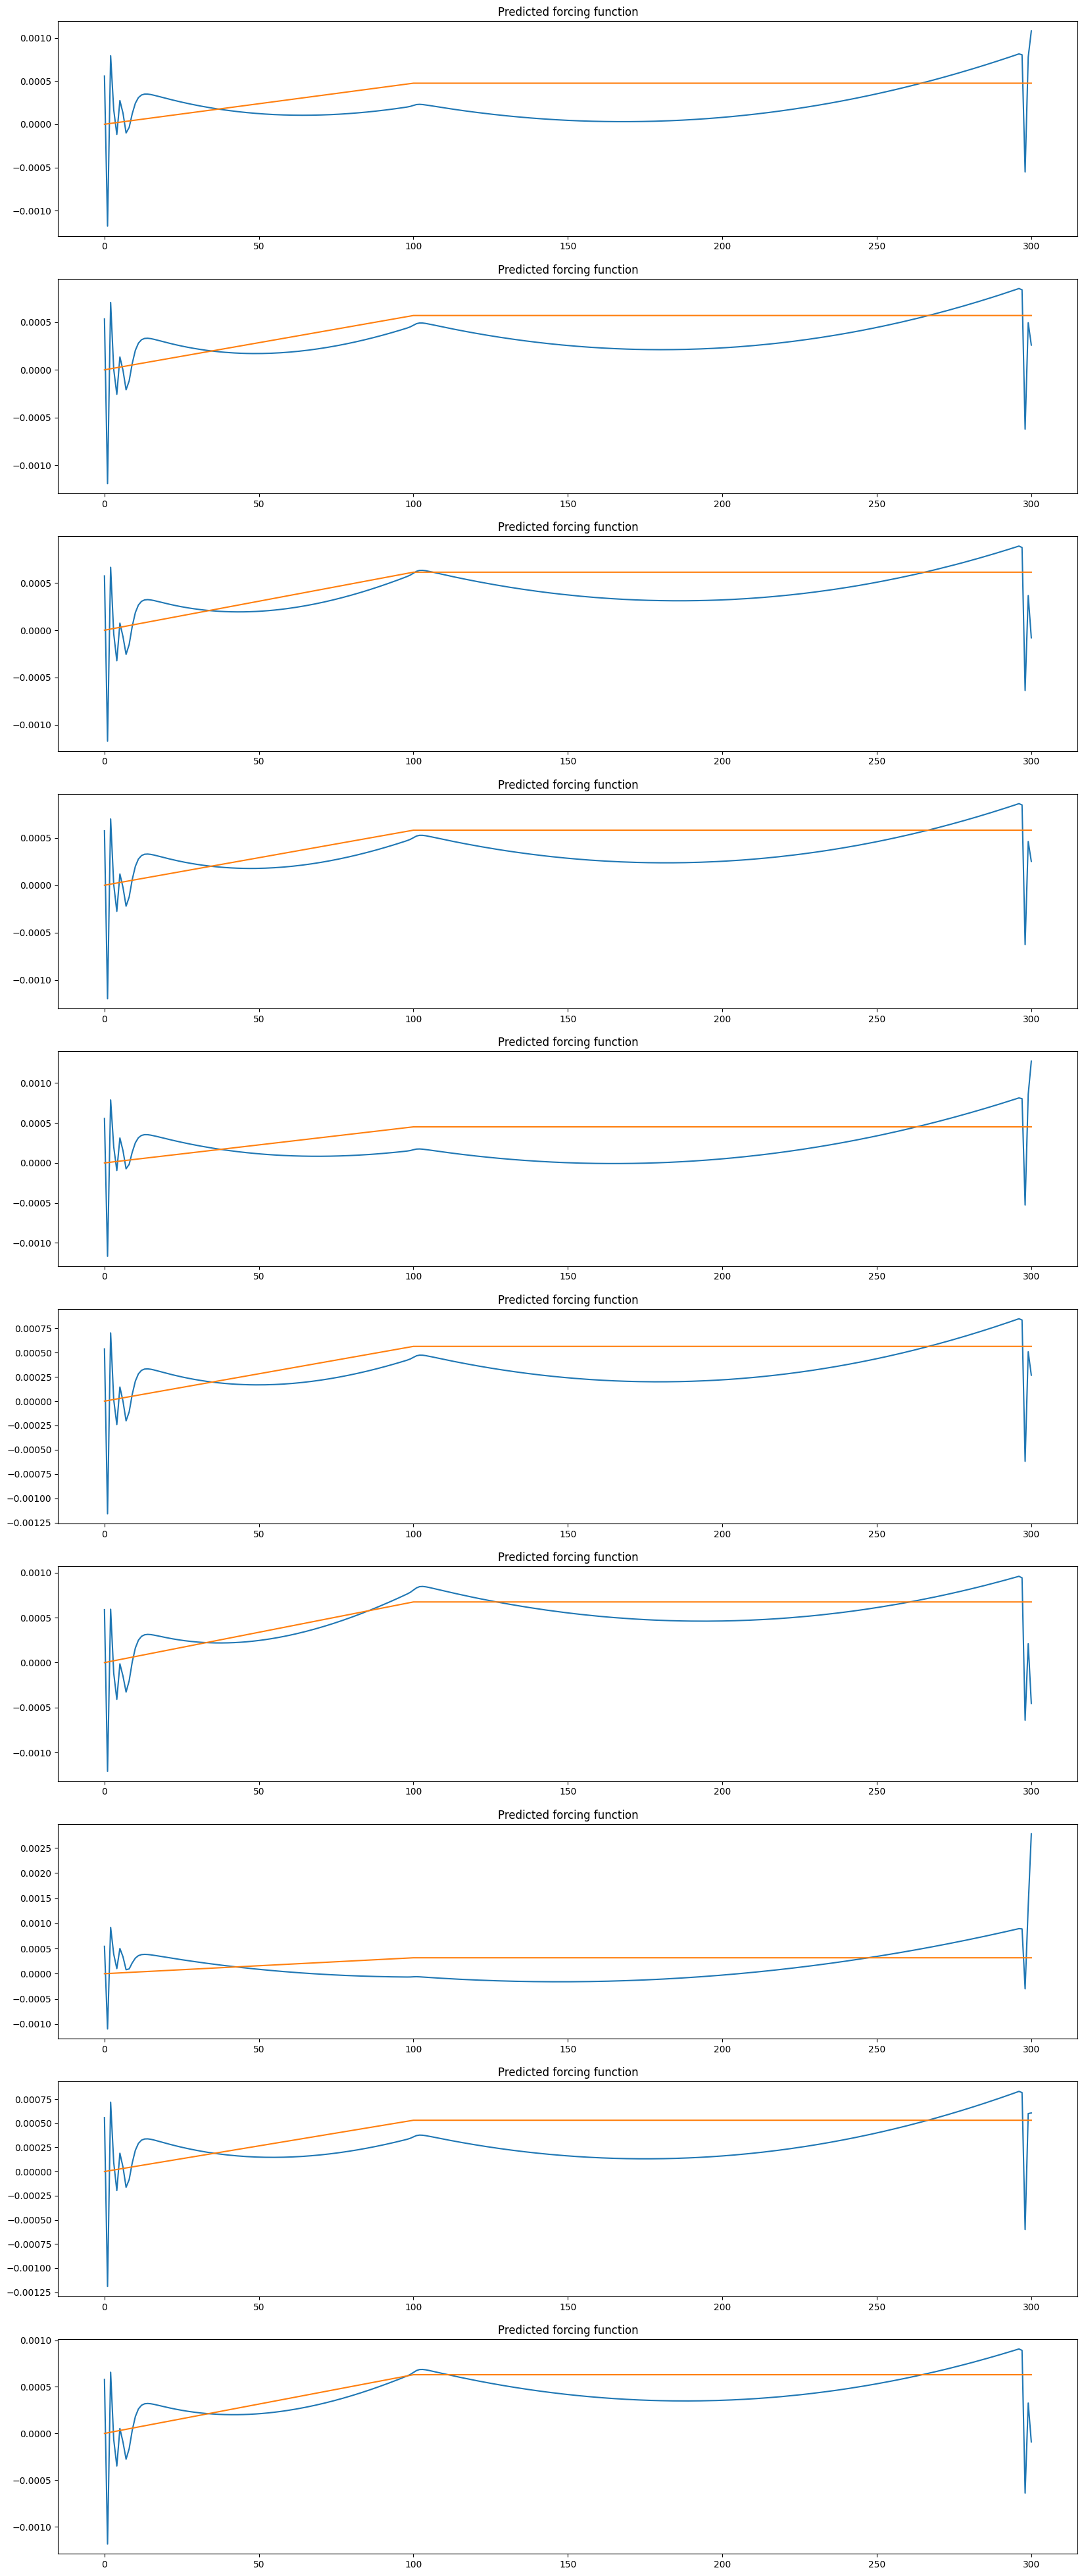

In [66]:
fig, ax = plt.subplots(n_samples_constant, 1, figsize=(20,5 * n_samples_constant))
for i in range(n_samples_constant):
    ax[i].plot(preds_all[i], label='Predicted')
    ax[i].set_title("Predicted forcing function")
    ax[i].plot(f_data_test[i], label='True')